In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Load the dataset
df = pd.read_csv("final_trial.csv")

# Load the words-emotion mapping CSV file
word_emotion_df = pd.read_csv("words_emotion.csv")

# Create a dictionary to map words to their corresponding emotion labels
word_emotion_mapping = dict(zip(word_emotion_df['Words'], word_emotion_df['Emotion']))

# Preprocess the text
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

def get_emotion_label(text):
    emotions = []
    for word in text.split():
        if word in word_emotion_mapping:
            emotions.append(word_emotion_mapping[word])
    return ' '.join(emotions)

df['clean_text'] = df['Poem'].apply(preprocess)
df['emotion_label'] = df['clean_text'].apply(get_emotion_label)

# Split the poem column into individual stanzas
df['stanzas'] = df['Poem'].apply(sent_tokenize)

# Convert emotions column to numerical labels
emotions = ['love', 'sad', 'anger', 'hate', 'fear', 'surprise', 'courage', 'joy', 'peace', 'hope', 'care']
label_encoder = LabelEncoder()
df['emotion_label'] = label_encoder.fit_transform(df['Emotion'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['stanzas'], df['emotion_label'], test_size=0.2, random_state=42)

# Tokenize the stanzas
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

# Pad the tokenized sequences
max_length = max([len(tokens) for tokens in X_train_tokens])
X_train_padded = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

# Build the CNN-BiLSTM model
embedding_dim = 100

model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(11, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=20, batch_size=32)

# Extract features using the trained model
feature_extractor = Sequential(model.layers[:6])
X_train_features = feature_extractor.predict(X_train_padded)
X_test_features = feature_extractor.predict(X_test_padded)

# Train the PassiveAggressiveClassifier on extracted features
classifier = PassiveAggressiveClassifier(random_state=42, max_iter=100)
classifier.fit(X_train_features, y_train)

# Evaluate the performance of the classifier
y_pred = classifier.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy * 100, "%")



Epoch 1/20
125/125 [==============================] - 6s 11ms/step - loss: 2.1802 - accuracy: 0.1979
Epoch 2/20
125/125 [==============================] - 1s 11ms/step - loss: 2.1243 - accuracy: 0.2007
Epoch 3/20
125/125 [==============================] - 1s 11ms/step - loss: 1.6286 - accuracy: 0.3946
Epoch 4/20
125/125 [==============================] - 1s 11ms/step - loss: 1.2059 - accuracy: 0.5590
Epoch 5/20
125/125 [==============================] - 1s 12ms/step - loss: 0.7944 - accuracy: 0.7412
Epoch 6/20
125/125 [==============================] - 1s 11ms/step - loss: 0.5063 - accuracy: 0.8359
Epoch 7/20
125/125 [==============================] - 1s 11ms/step - loss: 0.3721 - accuracy: 0.8785
Epoch 8/20
125/125 [==============================] - 1s 12ms/step - loss: 0.2734 - accuracy: 0.9158
Epoch 9/20
125/125 [==============================] - 1s 11ms/step - loss: 0.2180 - accuracy: 0.9308
Epoch 10/20
125/125 [==============================] - 1s 12ms/step - loss: 0.1907 - accura

In [4]:
# Use the trained model to predict the emotion of each stanza in a new poem
new_poem = """
Weavers, weaving at break of day,
Why do you weave a garment so gay?
Blue as the wing of a halcyon wild,
We weave the robes of a new-born child.

Weavers, weaving at fall of night,
Why do you weave a garment so bright?
Like the plumes of a peacock, purple and green,
We weave the marriage-veils of a queen.

Weavers, weaving solemn and still,
What do you weave in the moonlight chill? 
White as a feather and white as a cloud,
We weave a dead man's funeral shroud.
"""
new_stanzas = sent_tokenize(new_poem)
new_stanzas_tokens = tokenizer.texts_to_sequences(new_stanzas)
new_stanzas_padded = pad_sequences(new_stanzas_tokens, maxlen=max_length, padding='post')
new_stanzas_features = feature_extractor.predict(new_stanzas_padded)
new_stanzas_emotions = classifier.predict(new_stanzas_features)
new_stanzas_emotions = label_encoder.inverse_transform(new_stanzas_emotions)

for stanza, emotion in zip(new_stanzas, new_stanzas_emotions):
    print('Stanza:', stanza.strip())
    print('Emotion:', emotion)
    print("\n")


Stanza: Weavers, weaving at break of day,
Why do you weave a garment so gay?
Emotion: love


Stanza: Blue as the wing of a halcyon wild,
We weave the robes of a new-born child.
Emotion: sad


Stanza: Weavers, weaving at fall of night,
Why do you weave a garment so bright?
Emotion: courage


Stanza: Like the plumes of a peacock, purple and green,
We weave the marriage-veils of a queen.
Emotion: sad


Stanza: Weavers, weaving solemn and still,
What do you weave in the moonlight chill?
Emotion: love


Stanza: White as a feather and white as a cloud,
We weave a dead man's funeral shroud.
Emotion: sad




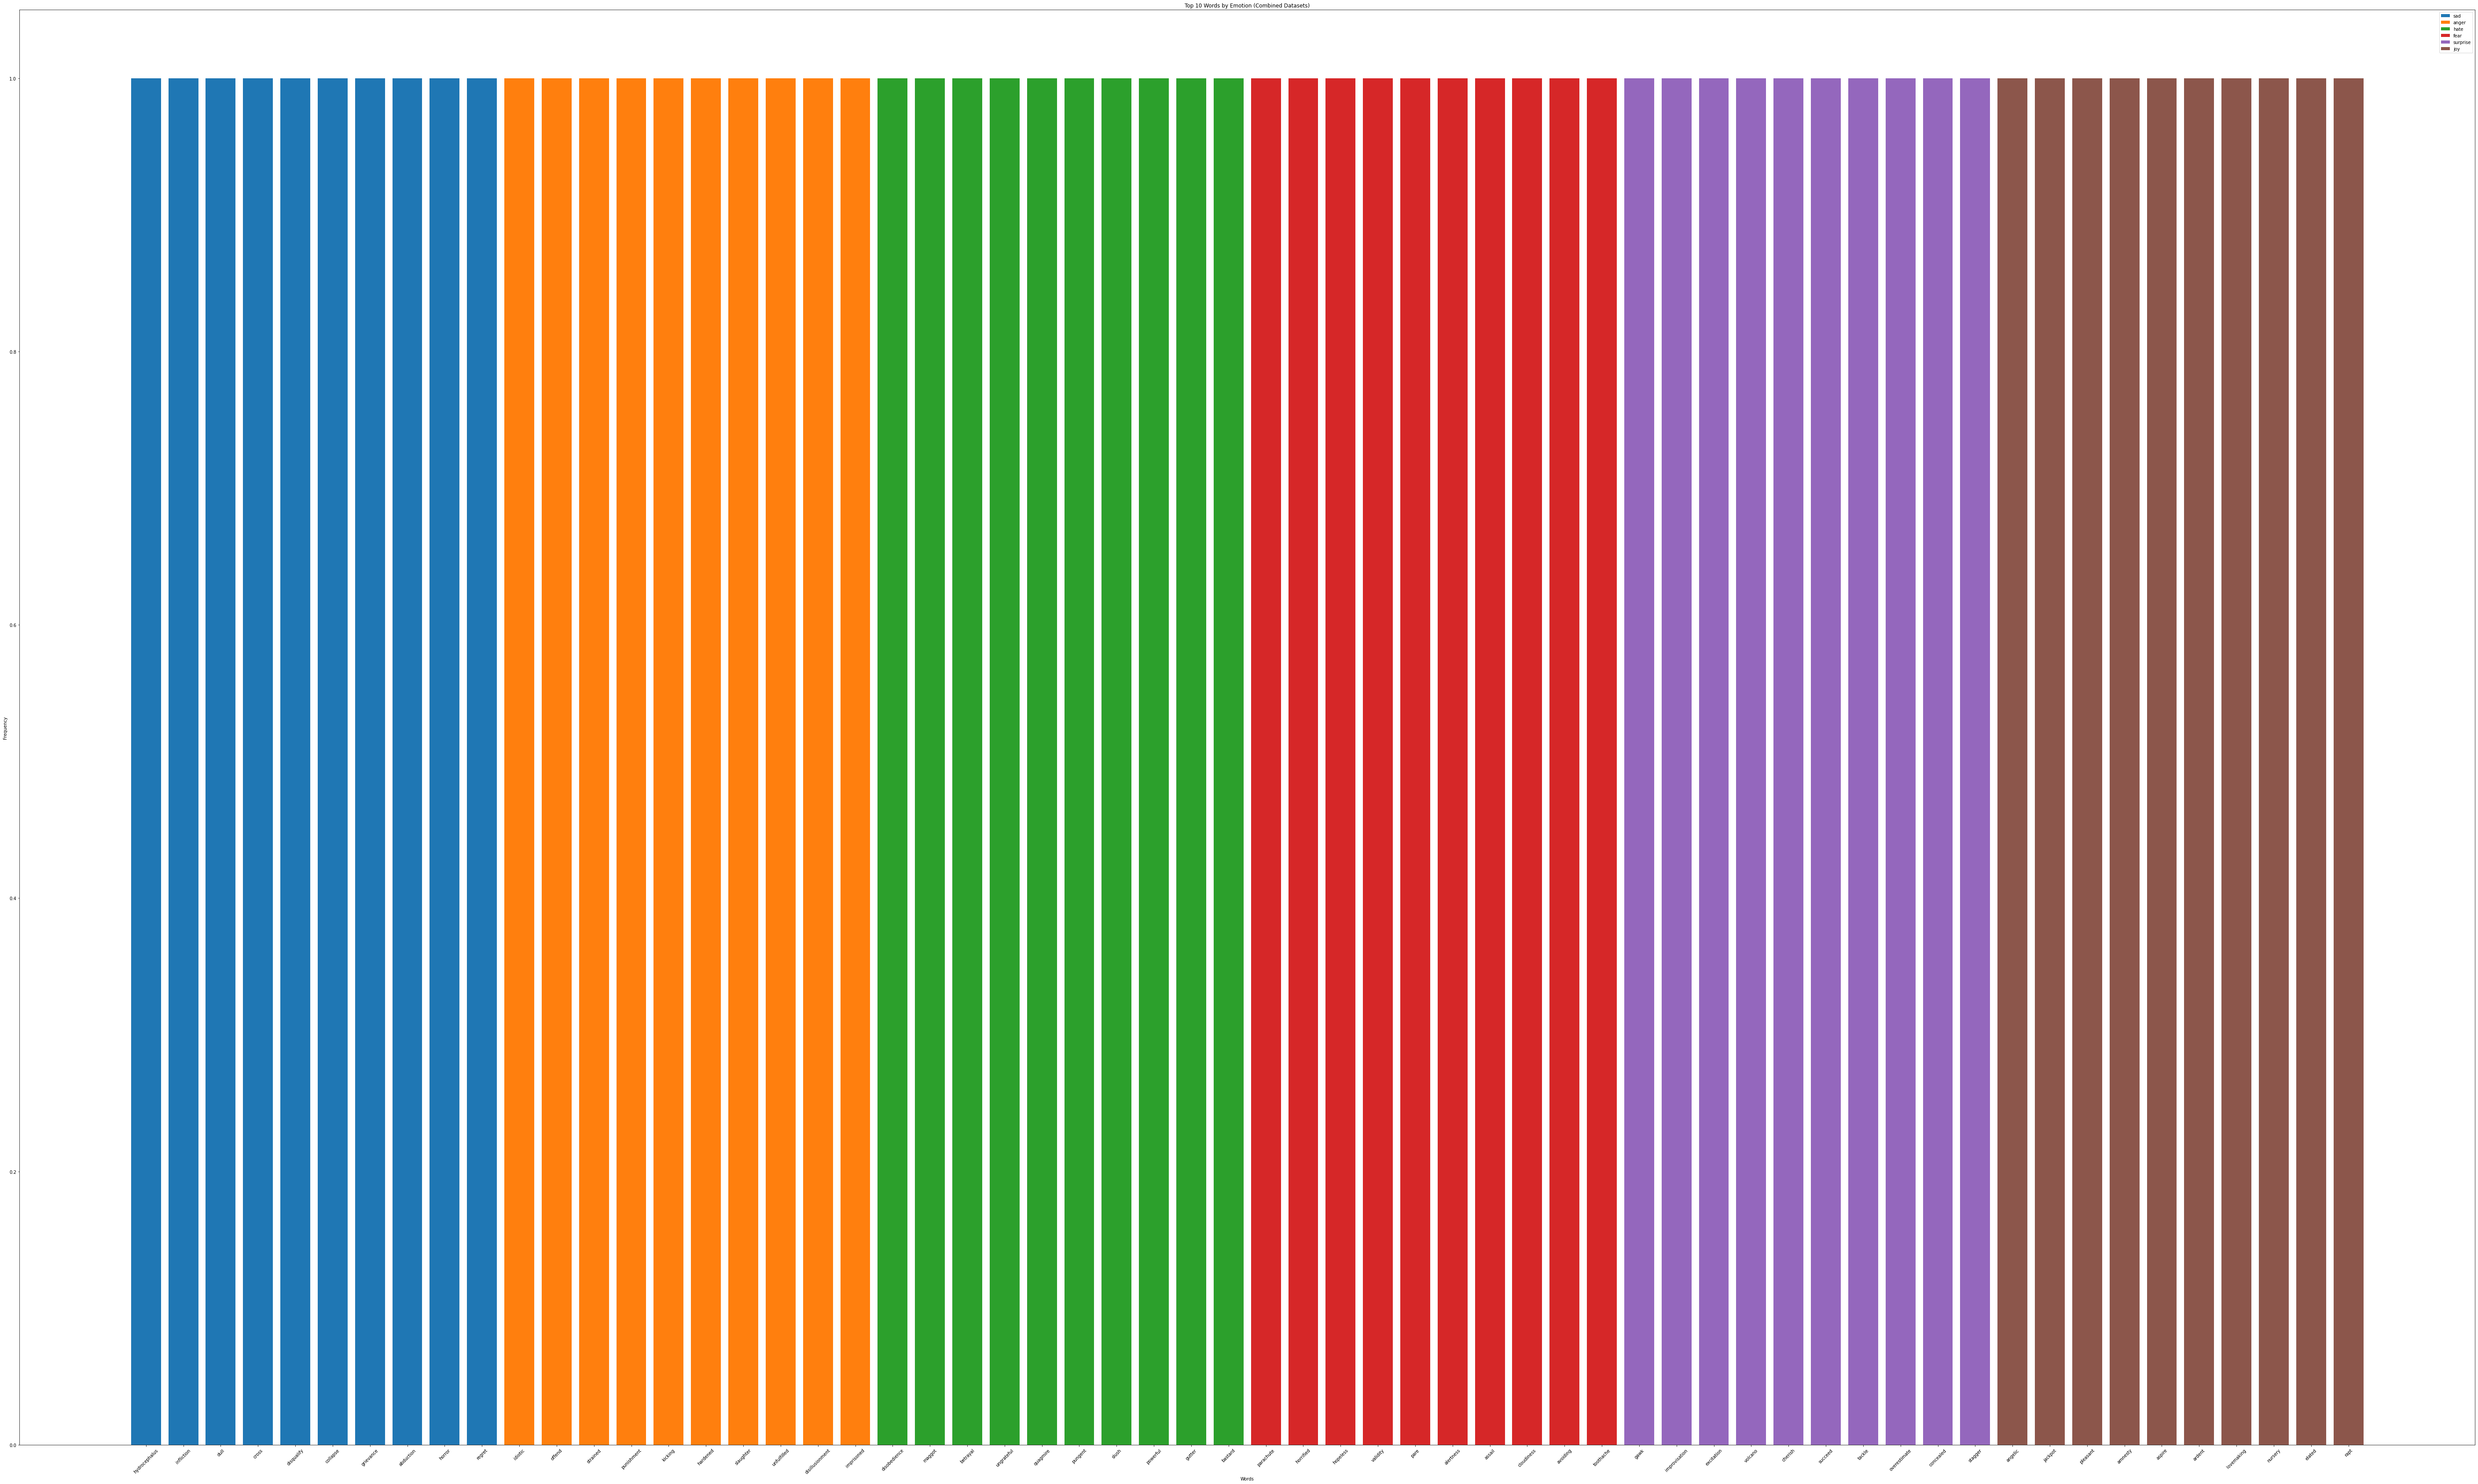

In [13]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk

# Load the dataset
df = pd.read_csv("final_trial.csv")

# Load the words-emotion mapping CSV file
word_emotion_df = pd.read_csv("words_emotion.csv")

# Create a dictionary to map words to their corresponding emotion labels
word_emotion_mapping = dict(zip(word_emotion_df['Words'], word_emotion_df['Emotion']))

# Preprocess the text
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

def get_emotion_label(text):
    emotions = []
    for word in text.split():
        if word in word_emotion_mapping:
            emotions.append(word_emotion_mapping[word])
    return ' '.join(emotions)

df['clean_text'] = df['Poem'].apply(preprocess)
df['emotion_label'] = df['clean_text'].apply(get_emotion_label)

# Convert emotions column to numerical labels
emotions = ['love', 'sad', 'anger', 'hate', 'fear', 'surprise', 'courage', 'joy', 'peace', 'hope', 'care']
label_encoder = LabelEncoder()
df['emotion_label'] = label_encoder.fit_transform(df['emotion_label'])

# Calculate word frequencies for each emotion label in the final_trial.csv dataset
word_frequencies_final_trial = {}
for emotion in emotions:
    # Get stanzas for the current emotion
    stanzas = df[df['emotion_label'] == emotion]['clean_text']
    # Concatenate all stanzas into a single string
    text = ' '.join(stanzas)
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Calculate word frequencies
    frequencies = nltk.FreqDist(tokens)
    # Store the word frequencies for the current emotion
    word_frequencies_final_trial[emotion] = frequencies

# Convert "Words" column to string in words_emotion_df
word_emotion_df['Words'] = word_emotion_df['Words'].astype(str)

# Calculate word frequencies for each emotion label in the words_emotion.csv dataset
word_frequencies_word_emotion = {}
for emotion in emotions:
    # Get words for the current emotion
    words = word_emotion_df[word_emotion_df['Emotion'] == emotion]['Words']
    # Tokenize the words
    tokens = word_tokenize(' '.join(words))
    # Calculate word frequencies
    frequencies = nltk.FreqDist(tokens)
    # Store the word frequencies for the current emotion
    word_frequencies_word_emotion[emotion] = frequencies

# Combine the word frequencies from both datasets
combined_word_frequencies = {}
for emotion in emotions:
    combined_frequencies = word_frequencies_final_trial[emotion] + word_frequencies_word_emotion[emotion]
    combined_word_frequencies[emotion] = combined_frequencies

# Plot word frequencies for each emotion from combined datasets
plt.figure(figsize=(100, 60))
for emotion in emotions:
    frequencies = combined_word_frequencies[emotion]
    common_words = frequencies.most_common(10)  # Get top 10 most common words
    if common_words:  # Check if there are common words available
        words, counts = zip(*common_words)
        plt.bar(words, counts, label=emotion)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words by Emotion (Combined Datasets)')
plt.legend()
plt.xticks(rotation=45)
plt.show()
